Fit slope = 0.475, intercept = -1.775


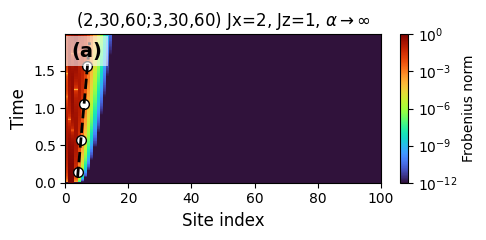

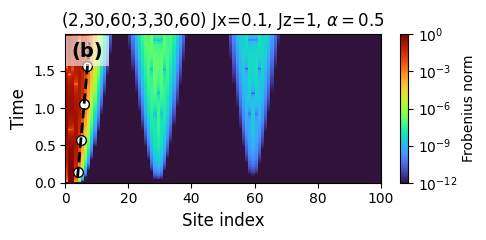

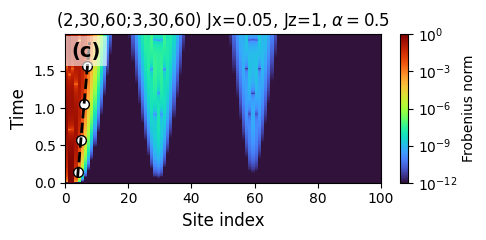

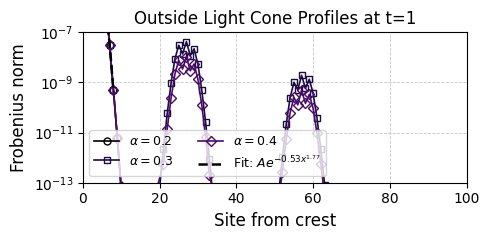

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([2,3,4])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))
arrivals = [
    (4, 0.15), (5, 0.57), (6, 1.06), (7, 1.57)
]
x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times
# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
# x_fit = np.linspace(x_points.min(), x_points.max(), 200)
x_fit = np.linspace(3.9, 7.7, 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")
# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N100b3varyalphanoKac{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 2.5))
    im = plt.imshow(
        np.clip(raw_data, 1e-12, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-12, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )
    # Overlay first arrival points
    plt.plot(x_points, y_points, 'wo', markersize=7,
            markeredgecolor="k", label="First arrivals")

    # Overlay best-fit line
    plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

    label_dict = {j: f"({chr(96 + i)})" for i, j in enumerate(Jlong_values, start=1)}
    label = label_dict.get(J, "(?)")


    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.xlim(0, 100)
    plt.title(fr"(2,30,60;3,30,60) Jx=0.05, Jz=1, $\alpha=0.5$", fontsize=12)
    if J == 3:
         plt.title(fr"(2,30,60;3,30,60) Jx=0.1, Jz=1, $\alpha=0.5$", fontsize=12)
    if J == 2:
         plt.title(fr"(2,30,60;3,30,60) Jx=2, Jz=1, $\alpha \to \infty$", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_alpha2{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(5, 2.5))

# Six shades that darken as α increases (use perceptually uniform colormap)
cmap = plt.cm.inferno
colors = [cmap(i / 9) for i in range(0,9)]

# Six distinct markers
markers = ["o", "s", "D", "^", "v", "x", "p", "*", "h"]


all_x_fit, all_y_fit = [], []

# Jlong_values here encode α×10 (e.g., 0,5,10,...,1000 -> α=0.0,...,1.0)
for (J, c, m) in zip(Jlong_values, colors, markers):
    file_path = os.path.join(base_path, f"N100b3varyalphanoKac{J}.txt")
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found, skipping.")
        continue

    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 3:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect points for global fit
    n_fit = 8
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])

    # Proper label (remove b since it's fixed)
    if J == 1000:
        label = r"$\alpha\!\to\!\infty$"
    else:
        label = fr"$\alpha={J/10:.1f}$"

    # Connected lines with open markers and darkening color
    plt.semilogy(
        sites, profile, '-', marker=m,
        markerfacecolor='none',
        markeredgecolor=c,
        color=c,
        markersize=5,
        linewidth=1.2,
        label=label
    )

# -----------------------------
# Global exponential fit
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Global fit line
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)
plt.semilogy(
    x_dense, y_dense, "k--", linewidth=1.8,
    label=fr"Fit: $A e^{{-{a_fit:.2f}x^{{{p_fit:.2f}}}}}$"
)

# -----------------------------
# Formatting
# -----------------------------
plt.ylim(1e-13, 1e-7)
plt.xlim(0, 100)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="lower left", ncol=2)
plt.tight_layout()
plt.savefig("plt/Profiles_VaryAlpha3.svg", dpi=600)
plt.show()



Fit slope = 0.475, intercept = -1.775


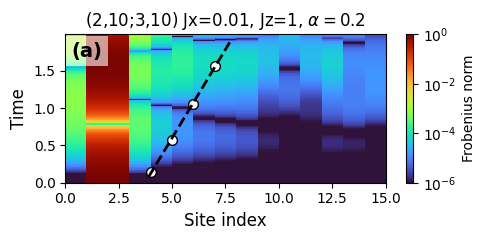

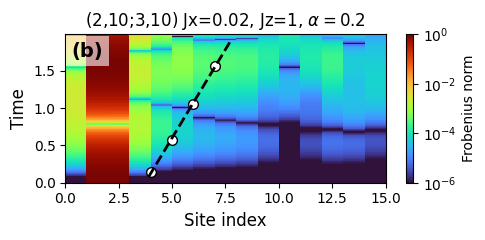

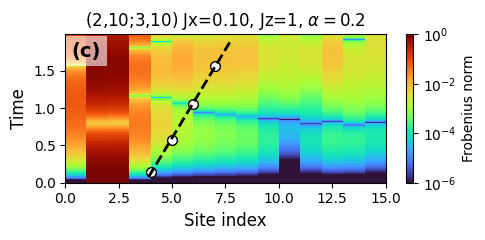

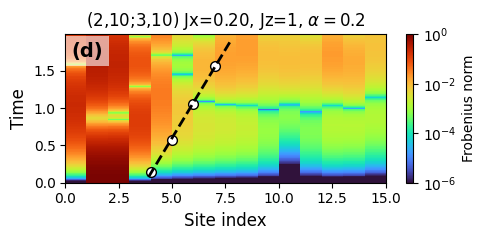

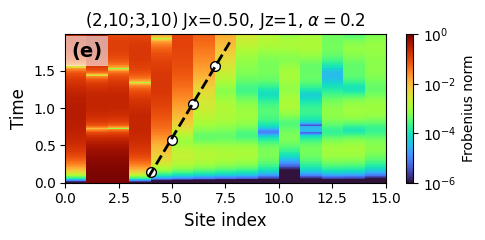

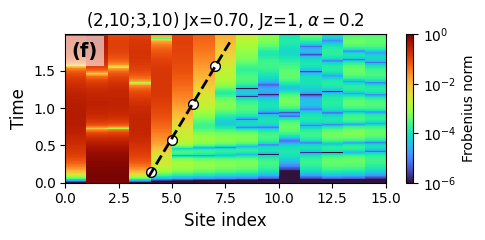

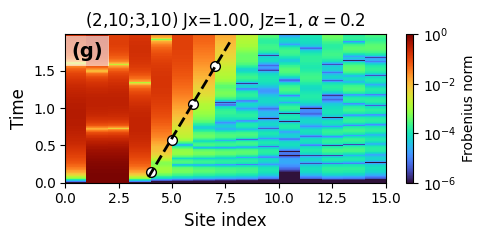

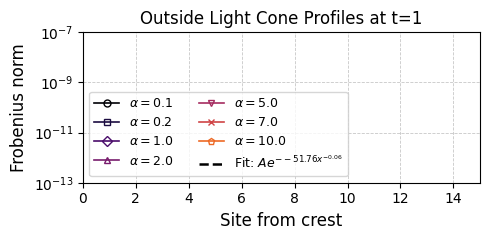

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([1, 2, 10, 20, 50, 70, 100])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))
arrivals = [
    (4, 0.15), (5, 0.57), (6, 1.06), (7, 1.57)
]
x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times
# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
# x_fit = np.linspace(x_points.min(), x_points.max(), 200)
x_fit = np.linspace(3.9, 7.7, 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")
# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N15Jz1a02b2JxVaried{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 2.5))
    im = plt.imshow(
        np.clip(raw_data, 1e-12, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-6, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )
    # Overlay first arrival points
    plt.plot(x_points, y_points, 'wo', markersize=7,
            markeredgecolor="k", label="First arrivals")

    # Overlay best-fit line
    plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

    label_dict = {j: f"({chr(96 + i)})" for i, j in enumerate(Jlong_values, start=1)}
    label = label_dict.get(J, "(?)")


    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.xlim(0, 15)
    plt.title(fr"(2,10;3,10) Jx={J/100:.2f}, Jz=1, $\alpha=0.2$", fontsize=12)
    # if J == 3:
    #      plt.title(fr"(2,30,60;3,30,60) Jx=0.1, Jz=1, $\alpha=0.5$", fontsize=12)
    # if J == 2:
    #      plt.title(fr"(2,30,60;3,30,60) Jx=2, Jz=1, $\alpha \to \infty$", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_alpha2{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(5, 2.5))

# Six shades that darken as α increases (use perceptually uniform colormap)
cmap = plt.cm.inferno
colors = [cmap(i / 9) for i in range(0,9)]

# Six distinct markers
markers = ["o", "s", "D", "^", "v", "x", "p", "*", "h"]


all_x_fit, all_y_fit = [], []

# Jlong_values here encode α×10 (e.g., 0,5,10,...,1000 -> α=0.0,...,1.0)
for (J, c, m) in zip(Jlong_values, colors, markers):
    file_path = os.path.join(base_path, f"N15Jz1a02b2JxVaried{J}.txt")
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found, skipping.")
        continue

    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 3:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect points for global fit
    n_fit = 8
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])

    # Proper label (remove b since it's fixed)
    if J == 1000:
        label = r"$\alpha\!\to\!\infty$"
    else:
        label = fr"$\alpha={J/10:.1f}$"

    # Connected lines with open markers and darkening color
    plt.semilogy(
        sites, profile, '-', marker=m,
        markerfacecolor='none',
        markeredgecolor=c,
        color=c,
        markersize=5,
        linewidth=1.2,
        label=label
    )

# -----------------------------
# Global exponential fit
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Global fit line
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)
plt.semilogy(
    x_dense, y_dense, "k--", linewidth=1.8,
    label=fr"Fit: $A e^{{-{a_fit:.2f}x^{{{p_fit:.2f}}}}}$"
)

# -----------------------------
# Formatting
# -----------------------------
plt.ylim(1e-13, 1e-7)
plt.xlim(0, 15)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="lower left", ncol=2)
plt.tight_layout()
plt.savefig("plt/Profiles_VaryAlpha3.svg", dpi=600)
plt.show()

